# Predict steel plate faults

Before proceeding, review the [API quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html) to ensure that your client and API credentials have been properly configured.

To run this notebook on your own, click the download icon in the top right of the page.

* [Download training data](https://s3.amazonaws.com/datarobot-use-case-datasets/steel_plates_fault_training.csv)
* [Download prediction data](https://s3.amazonaws.com/datarobot-use-case-datasets/steel_plates_fault_testing.csv)

## Setup

### Import libraries

In [2]:
!pip install datarobot umap-learn nbformat hdbscan

In [7]:
%matplotlib inline

import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

light_blue = "#598fd6"
grey_blue = "#5f728b"
orange = "#dd6b3d"

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Import data

DataRobot hosts the dataset used in this notebook via the URL used in the snippet below. Read in the data directly from the URL into a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and display the results to verify all of the data looks correct.

In [9]:
data_path = "https://s3.amazonaws.com/datarobot-use-case-datasets/steel_plates_fault_training.csv"

pathfinder_df = pd.read_csv(data_path, encoding="ISO-8859-1")

pathfinder_df.head(100)

X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0          42         50     270900     270944           267           17   
1         645        651    2538079    2538108           108           10   
2         853        860     369370     369415           176           13   
3        1289       1306     498078     498335          2409           60   
4         430        441     100250     100337           630           20   
..        ...        ...        ...        ...           ...          ...   
95       1554       1564    3375744    3375765           134           13   
96        980        992     333332     333435           970           57   
97       1579       1592     562576     562633           515           32   
98        225        235     719009     719024           116           17   
99       1465       1486    1837263    1837460          2490          146   

    Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            44              24220                     76   
1            30              11397                     84   
2            45              18996                     99   
3           260             246930                     37   
4            87              62357                     64   
..          ...                ...                    ...   
95           21              13356                     89   
96          103              97514                     66   
97           57              41622                     46   
98           15              11656                     71   
99          197             283038                     19   

    Maximum_of_Luminosity  ...  Edges_X_Index  Edges_Y_Index  \
0                     108  ...         0.4706         1.0000   
1                     123  ...         0.6000         0.9667   
2                     126  ...         0.5385         1.0000   
3                     126  ...         0.2833         0.9885   
4                     127  ...         0.5500         1.0000   
..                    ...  ...            ...            ...   
95                    111  ...         0.7692         1.0000   
96                    133  ...         0.2105         1.0000   
97                    108  ...         0.4063         1.0000   
98                    127  ...         0.5882         1.0000   
99                    141  ...         0.1438         1.0000   

    Outside_Global_Index  LogOfAreas  Log_X_Index  Log_Y_Index  \
0                    1.0      2.4265       0.9031       1.6435   
1                    1.0      2.0334       0.7782       1.4624   
2                    1.0      2.2455       0.8451       1.6532   
3                    1.0      3.3818       1.2305       2.4099   
4                    1.0      2.7993       1.0414       1.9395   
..                   ...         ...          ...          ...   
95                   1.0      2.1271       1.0000       1.3222   
96                   1.0      2.9868       1.0792       2.0128   
97                   1.0      2.7118       1.1139       1.7559   
98                   1.0      2.0645       1.0000       1.1761   
99                   1.0      3.3962       1.3222       2.2945   

    Orientation_Index  Luminosity_Index  SigmoidOfAreas  Fault  
0              0.8182           -0.2913          0.5822      0  
1              0.7931           -0.1756          0.2984      0  
2              0.8444           -0.1568          0.5212      0  
3              0.9338           -0.1992          1.0000      0  
4              0.8736           -0.2267          0.9874      0  
..                ...               ...             ...    ...  
95             0.5238           -0.2213          0.3509      0  
96             0.8835           -0.2146          0.9980      0  
97             0.7719           -0.3686          0.9491      0  
98             0.3333           -0.2150          0.2660      0  
99             0.8934           -0.1120          1.0000      0  

[10

### Visualize data

Below, view several examples of charts that visualize the dataset in different ways, such as grouping by plate thickness.

In [10]:
total_count_df = pathfinder_df.groupby("Fault").count()
total_count_df = total_count_df.reset_index()

total_count_df

Fault  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0      0       1153       1153       1153       1153          1153   
1      1        615        615        615        615           615   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  ...  \
0         1153         1153               1153                   1153  ...   
1          615          615                615                    615  ...   

   Outside_X_Index  Edges_X_Index  Edges_Y_Index  Outside_Global_Index  \
0             1153           1153           1153                  1153   
1              615            615            615                   615   

   LogOfAreas  Log_X_Index  Log_Y_Index  Orientation_Index  Luminosity_Index  \
0        1153         1153         1153               1153              1153   
1         615          615          615                615               615   

   SigmoidOfAreas  
0            1153  
1             615  

[2 rows x 28 columns]

In [11]:
pathfinder_df

X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0            42         50     270900     270944           267           17   
1           645        651    2538079    2538108           108           10   
2           853        860     369370     369415           176           13   
3          1289       1306     498078     498335          2409           60   
4           430        441     100250     100337           630           20   
...         ...        ...        ...        ...           ...          ...   
1763        249        277     325780     325796           273           54   
1764        144        175     340581     340598           287           44   
1765        145        174     386779     386794           292           40   
1766        137        170     422497     422528           419           97   
1767       1261       1281      87951      87967           103           26   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0              44              24220                     76   
1              30              11397                     84   
2              45              18996                     99   
3             260             246930                     37   
4              87              62357                     64   
...           ...                ...                    ...   
1763           22              35033                    119   
1764           24              34599                    112   
1765           22              37572                    120   
1766           47              52715                    117   
1767           22              11682                    101   

      Maximum_of_Luminosity  ...  Edges_X_Index  Edges_Y_Index  \
0                       108  ...         0.4706         1.0000   
1                       123  ...         0.6000         0.9667   
2                       126  ...         0.5385         1.0000   
3                       126  ...         0.2833         0.9885   
4                       127  ...         0.5500         1.0000   
...                     ...  ...            ...            ...   
1763                    141  ...         0.5185         0.7273   
1764                    133  ...         0.7046         0.7083   
1765                    140  ...         0.7250         0.6818   
1766                    140  ...         0.3402         0.6596   
1767                    133  ...         0.7692         0.7273   

      Outside_Global_Index  LogOfAreas  Log_X_Index  Log_Y_Index  \
0                      1.0      2.4265       0.9031       1.6435   
1                      1.0      2.0334       0.7782       1.4624   
2                      1.0      2.2455       0.8451       1.6532   
3                      1.0      3.3818       1.2305       2.4099   
4                      1.0      2.7993       1.0414       1.9395   
...                    ...         ...          ...          ...   
1763                   0.0      2.4362       1.4472       1.2041   
1764                   0.0      2.4579       1.4914       1.2305   
1765                   0.0      2.4654       1.4624       1.1761   
1766                   0.0      2.6222       1.5185       1.4914   
1767                   0.0      2.0128       1.3010       1.2041   

      Orientation_Index  Luminosity_Index  SigmoidOfAreas  Fault  
0                0.8182           -0.2913          0.5822      0  
1                0.7931           -0.1756          0.2984      0  
2                0.8444           -0.1568          0.5212      0  
3                0.9338           -0.1992          1.0000      0  
4                0.8736           -0.2267          0.9874      0  
...                 ...               ...             ...    ...  
1763            -0.4286            0.0026          0.7254      1  
1764            -0.4516           -0.0582          0.8173      1  
1765            -0.4828            0.0052          0.7079      1  
1766            -0.0

In [12]:
df = pathfinder_df.groupby("Steel_Plate_Thickness").count()
df = df.reset_index()
df

Steel_Plate_Thickness  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  \
0                      40        653        653        653        653   
1                      50        104        104        104        104   
2                      60         82         82         82         82   
3                      69         36         36         36         36   
4                      70        342        342        342        342   
5                      80        132        132        132        132   
6                      85          4          4          4          4   
7                      90         19         19         19         19   
8                     100        137        137        137        137   
9                     120         21         21         21         21   
10                    125          5          5          5          5   
11                    130          8          8          8          8   
12                    140          1          1          1          1   
13                    143         17         17         17         17   
14                    150         25         25         25         25   
15                    175         31         31         31         31   
16                    180          2          2          2          2   
17                    185         14         14         14         14   
18                    200         72         72         72         72   
19                    211          5          5          5          5   
20                    220         15         15         15         15   
21                    250          1          1          1          1   
22                    290          2          2          2          2   
23                    300         40         40         40         40   

    Pixels_Areas  X_Perimeter  Y_Perimeter  Sum_of_Luminosity  \
0            653          653          653                653   
1            104          104          104                104   
2             82           82           82                 82   
3             36           36           36                 36   
4            342          342          342                342   
5            132          132          132                132   
6              4            4            4                  4   
7             19           19           19                 19   
8            137          137          137                137   
9             21           21           21                 21   
10             5            5            5                  5   
11             8            8            8                  8   
12             1            1            1                  1   
13            17           17           17                 17   
14            25           25           25                 25   
15            31           31           31                 31   
16             2            2            2                  2   
17            14           14           14                 14   
18            72           72           72                 72   
19             5            5            5                  5   
20            15           15           15                 15   
21             1            1            1                  1   
22             2            2            2                  2   
23            40           40           40                 40   

    Minimum_of_Luminosity  ...  Edges_X_Index  Edges_Y_Index  \
0                     653  ...            653            653   
1                     104  ...            104            104   
2                      82  ...             82             82   
3                      36  ...             36             36   
4                     342  ...            342            342   
5                     132  ...            132            132   
6                       4  ...              4              4   
7                      19  ...          

## Modeling
 
For this use case, create a DataRobot project and initiate modeling by running Autopilot in Quick mode.

In [13]:
EXISTING_PROJECT_ID = None  # If you've already created a project, replace None with the ID here
if EXISTING_PROJECT_ID is None:
    # Create project and pass in data
    project = dr.Project.create(sourcedata=pathfinder_df, project_name="Predict steel plate fault")

    # Set the project target to the appropriate feature. Use the LogLoss metric to measure performance
    project.set_target(target="Fault", mode=dr.AUTOPILOT_MODE.QUICK, worker_count="-1")
else:
    # Fetch the existing project
    project = dr.Project.get(EXISTING_PROJECT_ID)

project.wait_for_autopilot(check_interval=30)
# Get the project metric (i.e LogLoss, RMSE, etc.)
metric = project.metric

# Get the project ID
# project_id = project.id
# project_id

In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 1s)
In progress: 9, queued: 0 (waited: 2s)
In progress: 9, queued: 0 (waited: 3s)
In progress: 9, queued: 0 (waited: 5s)
In progress: 9, queued: 0 (waited: 9s)
In progress: 9, queued: 0 (waited: 16s)
In progress: 9, queued: 0 (waited: 29s)
In progress: 0, queued: 0 (waited: 55s)
In progress: 7, queued: 0 (waited: 85s)
In progress: 1, queued: 0 (waited: 116s)
In progress: 0, queued: 0 (waited: 146s)
In progress: 0, queued: 0 (waited: 176s)
In progress: 5, queued: 0 (waited: 207s)
In progress: 1, queued: 0 (waited: 237s)
In progress: 1, queued: 0 (waited: 268s)
In progress: 1, queued: 0 (waited: 298s)
In progress: 1, queued: 0 (waited: 328s)
In progress: 1, queued: 0 (waited: 359s)
In progress: 1, queued: 0 (waited: 389s)
In progress: 1, queued: 0 (waited: 419s)
In progress: 0, queued: 0 (waited: 450s)
In progress: 0, queued: 0 (waited: 480s)


### View the project in the UI

If you want to view the project in the DataRobot UI, use the following snippet to retrieve the project's URL and use it to navigate to the application.

In [14]:
# Get project URL
project_url = project.get_leaderboard_ui_permalink()
print(project_url)

https://app.datarobot.com/projects/62fe52e5a983f84bf4b101ae/models


## Evaluate model performance 

In order to measure model performance, first select the top-performing model based on a specific performance metric (i.e., `LogLoss`) and then evaluate several different types of charts, such as Lift Chart, ROC Curve, and Feature Importance. There are two helper functions that you need to build in order simplify producing these model insights.

You can reference more information about model evaluation tools [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/index.html).

In [15]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if model.metrics[metric][test_set] is not None]

    return sorted(models_with_score, key=lambda model: model.metrics[metric][test_set])

In [16]:
models = project.get_models()

# Uncomment if this is not set above in the create project paragraph
metric = project.metric

# Get top performing model
model_top = sorted_by_metric(models, "crossValidation", metric)[0]

print(
    """The top performing model is {model} using metric, {metric}""".format(
        model=str(model_top), metric=metric
    )
)

The top performing model is Model('AVG Blender') using metric, LogLoss


In [17]:
# Set styling
dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"

# Create function to build Historgrams


def rebin_df(raw_df, number_of_bins):
    cols = ["bin", "actual_mean", "predicted_mean", "bin_weight"]
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data["predicted"] * data["bin_weight"]
        current_actual_total += data["actual"] * data["bin_weight"]
        current_row_total += data["bin_weight"]

        if (rowId + 1) % bin_size == 0:
            x_index += 1
            bin_properties = {
                "bin": ((round(rowId + 1) / 60) * number_of_bins),
                "actual_mean": current_actual_total / current_row_total,
                "predicted_mean": current_prediction_total / current_row_total,
                "bin_weight": current_row_total,
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df

### Lift chart

A [lift chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) shows you how close model predictions are to the actual values of the target in the training data. The lift chart data includes the average predicted value and the average actual values.

In [18]:
# Create function to build lift charts


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["predicted_mean"],
        marker="+",
        lw=1,
        color=dr_blue,
        label="predicted",
    )
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["actual_mean"],
        marker="*",
        lw=1,
        color=dr_orange,
        label="actual",
    )
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(bin_count))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")
    return grouped

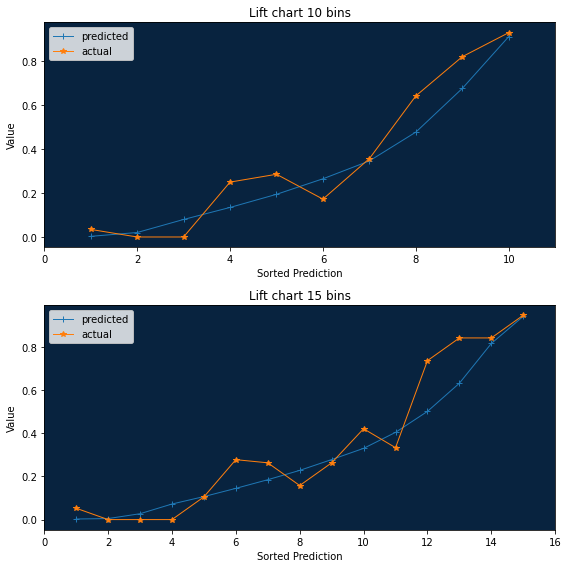

In [19]:
lift_chart = model_top.get_lift_chart("validation")

# Save the result into a pandas dataframe
lift_df = pd.DataFrame(lift_chart.bins)

bin_counts = [10, 15]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(lift_df, bin_counts[i], axarr[i]))

plt.tight_layout()
# plt.show()

### ROC curve

The receiver operating characteristic curve, or [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

In [20]:
roc = model_top.get_roc_curve("validation")

# Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

roc_df

accuracy  f1_score  false_negative_score  true_negative_score  \
0    0.650177  0.000000                    99                  184   
1    0.653710  0.020000                    98                  184   
2    0.660777  0.058824                    96                  184   
3    0.671378  0.114286                    93                  184   
4    0.674912  0.148148                    91                  183   
..        ...       ...                   ...                  ...   
107  0.388693  0.533693                     0                   11   
108  0.381625  0.530831                     0                    9   
109  0.371025  0.526596                     0                    6   
110  0.360424  0.522427                     0                    3   
111  0.349823  0.518325                     0                    0   

     true_positive_score  false_positive_score  true_negative_rate  \
0                      0                     0            1.000000   
1                      1                     0            1.000000   
2                      3                     0            1.000000   
3                      6                     0            1.000000   
4                      8                     1            0.994565   
..                   ...                   ...                 ...   
107                   99                   173            0.059783   
108                   99                   175            0.048913   
109                   99                   178            0.032609   
110                   99                   181            0.016304   
111                   99                   184            0.000000   

     false_positive_rate  true_positive_rate  \
0               0.000000            0.000000   
1               0.000000            0.010101   
2               0.000000            0.030303   
3               0.000000            0.060606   
4               0.005435            0.080808   
..                   ...                 ...   
107             0.940217            1.000000   
108             0.951087            1.000000   
109             0.967391            1.000000   
110             0.983696            1.000000   
111             1.000000            1.000000   

     matthews_correlation_coefficient  positive_predictive_value  \
0                            0.000000                   0.000000   
1                            0.081183                   1.000000   
2                            0.141115                   1.000000   
3                            0.200644                   1.000000   
4                            0.204855                   0.888889   
..                                ...                        ...   
107                          0.147510                   0.363971   
108                          0.132940                   0.361314   
109                          0.107955                   0.357401   
110                          0.075926                   0.353571   
111                          0.000000                   0.349823   

     negative_predictive_value  threshold  fraction_predicted_as_positive  \
0                     0.650177   1.000000                        0.000000   
1                     0.652482   0.985556                        0.003534   
2                     0.657143   0.983075                        0.010601   
3                     0.664260   0.959606                        0.021201   
4                     0.667883   0.953366                        0.031802   
..                         ...        ...                             ...   
107                   1.000000   0.002711                        0.961131   
108                   1.000000   0.002690                        0.968198   
109                   1.000000   0.002546                        0.978799   
110                   1.000000   0.002377                        0.989399   
111                   0.000000   0.002022                        1.000000   

    

In [ ]:
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"

threshold = roc.get_best_f1_threshold()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate")
plt.ylim([0, 1])

### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how important a feature is in the context of a model. It measures how much the accuracy of a model would decrease if that feature was removed.

Feature Impact is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once DataRobot computes the feature impact for a model, that information is saved with the project.

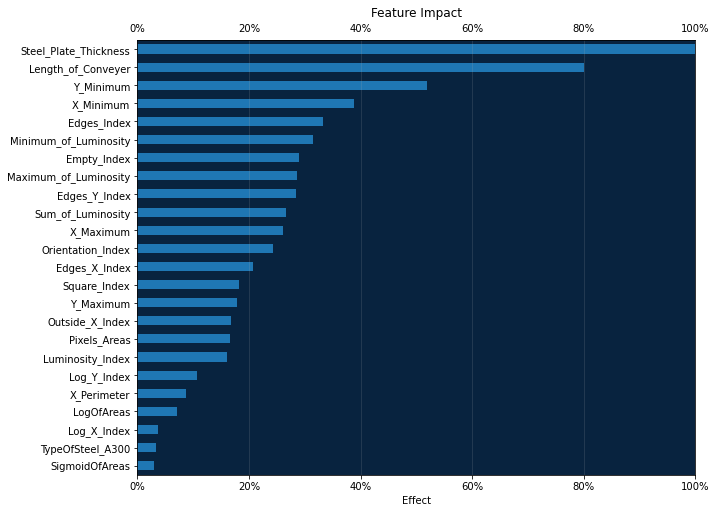

In [21]:
feature_impacts = model_top.get_or_request_feature_impact()

# Limit size to make chart look good. Display top 25 values
if len(feature_impacts) > 25:
    feature_impacts = feature_impacts[0:24]

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

ax = impact_df.plot.barh(
    x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 8)
)
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel("")
plt.xlabel("Effect")
plt.xlim((None, 1))  # Allow for negative impact
plt.title("Feature Impact", y=1.04);

## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload the prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. The predictions are returned as a Pandas dataframe. 

In [22]:
data_path_scoring = (
    "https://s3.amazonaws.com/datarobot-use-case-datasets/steel_plates_fault_testing.csv"
)
scoring_df = pd.read_csv(data_path_scoring, encoding="ISO-8859-1")
scoring_df = scoring_df.drop(columns=["Fault"])

prediction_dataset = project.upload_dataset(scoring_df)
predict_job = model_top.request_predictions(prediction_dataset.id)
prediction_dataset.id

predictions = predict_job.get_result_when_complete()
pd.concat([scoring_df, predictions], axis=1)
predictions.positive_probability.plot(kind="hist", title="Predicted Probabilities")

X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0          829        835    1553913    1553931            71            8   
1           46         58     179258     179312           480           15   
2         1617       1629     183688     183711           201           22   
3         1259       1271    1918092    1918128           324           30   
4           11         20    2845229    2845256           182           20   
..         ...        ...        ...        ...           ...          ...   
168       1673       1687    1891620    1891638            86           23   
169         18         40    2133912    2133915            54           22   
170        983       1005     895625     895642           102           42   
171        196        209     157035     157044            60           20   
172        271        291    1488866    1488885           204           38   

     Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0             19               7972                     99   
1             54              61966                    102   
2             23              20993                     79   
3             36              30269                     65   
4             27              16337                     72   
..           ...                ...                    ...   
168           18               6442                     28   
169            3               6479                     87   
170           22              12942                    114   
171           14               7508                    117   
172           22              23155                    105   

     Maximum_of_Luminosity  ...  Log_Y_Index  Orientation_Index  \
0                      125  ...       1.2553             0.6667   
1                      158  ...       1.7324             0.7778   
2                      126  ...       1.3617             0.4783   
3                      124  ...       1.5563             0.6667   
4                      109  ...       1.4314             0.6667   
..                     ...  ...          ...                ...   
168                    101  ...       1.2553             0.2222   
169                    158  ...       0.4771            -0.8636   
170                    141  ...       1.2305            -0.2273   
171                    135  ...       0.9542            -0.3077   
172                    126  ...       1.2787            -0.0500   

     Luminosity_Index  SigmoidOfAreas  row_id  prediction  \
0             -0.1228          0.2150       0         0.0   
1              0.0086          0.9093       1         0.0   
2             -0.1840          0.4564       2         1.0   
3             -0.2701          0.7037       3         0.0   
4             -0.2987          0.4025       4         0.0   
..                ...             ...     ...         ...   
168           -0.4148          0.4170     168         1.0   
169           -0.0626          0.1715     169         1.0   
170           -0.0087          0.6173     170         1.0   
171           -0.0224          0.2253     171         1.0   
172           -0.1132          0.6268     172         1.0   

     positive_probability  prediction_threshold  class_0.0  class_1.0  
0                0.186025                   0.5   0.813975   0.186025  
1                0.130302                   0.5   0.869698   0.130302  
2                0.749462                   0.5   0.250538   0.749462  
3                0.413906                   0.5   0.586094   0.413906  
4                0.191696                   0.5   0.808304   0.191696  
..                    ...                   ...        ...        ...  
168              0.617201                   0.5   0.382799   0.617201  
169              0.966580                   0.5   0.033420   0.966580  
170              0.860090                   0.5   0.139910   0.860090  
171              0.528807                   0.5   0.471193   0.52

### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [23]:
# Create a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    model_top.id,
    label="Steel Plate Fault Predictions",
    description="Predict Steel Plate Fault",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

Deployment(Steel Plate Fault Predictions)

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html)).

In [24]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established through the UI for easy scoring. Credentials are usernames and passwords, and data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

Reference the DataRobot documentation for more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [26]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

5e14e08b47047100148aad36


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
    )

# Scoring with Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
        max_explanations=3,  # Compute Prediction Explanations for the amount of features indicated here
    )

#### Score from S3 to S3

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
        },
        output_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scored2.csv",
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
        },
    )

#### Score from JDBC to JDBC

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "dataStoreId": data_store.id,  # Provide the ID of your datastore here
            "credentialId": cred.credential_id,  # Provide your credentials here
        },
        output_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "statementType": "insert",
            "dataStoreId": data_store.id,
            "credentialId": cred.credential_id,
        },
    )